# Overview of the Gradient Boosted Tree Classifier

Gradient Boosting is an ensemble learning method that takes many weak learners (with accuracy slightly above that of a random guess) and combines them sequentially to create a strong learner (model accuracy of >95%).

Advantages:
- Highly interpretable - the steps are intuitive
- Versatile - can be used for both classification and regression problems

Disadvantages:
- If the hyperparameters aren't tuned carefully, it is easy for the model to overfit the training data
- The model can become computationally expensive, as it requires subsequently training multiple weak learners

### Representation

We have chosen to implement Gradient Boosting for a classification problem, using a shallow decision tree as our weak learner. The final model $F(x)$ is therefore built from a sequence of $N$ trees, where each successive tree corrects the predictions from the previous iteration:

$F_{N}(x) = F_{0}(x) + \eta \sum_{i=1}^{N} h_{i}(x)$ 

Where:
- $F_{0}(x)$ is the initial prediction
- $\eta$ is the learning rate (a value between 0 and 1)
- $h_{i}(x)$ is the prediction made by decision tree $i$, trained on the residuals from the previous trees

We are not predicting class labels, but are instead predicting pseudo-residuals that will be used to correct the initial prediction.

### Loss

As this is a binary classification problem we will be using the Cross-Entropy loss/Log loss as our loss function. The function is:

$L(y, \hat{p}(x)) = -(y \cdot log(\hat{p}(x)) + (1-y) \cdot log(1-\hat{p}(x)))$

Where:
- $y$ are the true labels, 1 or 0
- $\hat{p}(x)$ is the probability predictor for the positive class, 1

### Optimizer

The optimizer is gradient descent on the pseudo-residuals

We calculate the pseudo-residuals as the negative gradient of the loss function with respect to the current model prediction:

$r_i = -\frac{\partial L(y, \hat{p}(x))}{\partial F(x)} = y - \hat{p}(x)$

Shallow decision trees are trained on the previous iteration residuals, which are then used to update the prediction

$F_{i+1}(x) = F_{i}(x) + \eta \cdot h_{i}(x)$ 

### Algorithm Pseudocode

**inputs:**

*training set:* $S = (x_1, y_1), ... , (x_m, y_m)$

*weak learner: decision tree classifier* $DTC$

*number of trees:* $N$

*learning rate:* $\eta$

**initialize:**

*set initial predictions as log-odds of the positive class:* $F_{0}(x) = logit(p_{y=1}) = log(\frac{p_{y=1}}{1-p_{y=1}})$ 

**for** $i = 0, ...,N-1:$

*compute the residuals:* $r_i = -\frac{\partial L(y, \hat{p}_{i}(x))}{\partial F_{i}(x)} = y - \hat{p}_{i}(x)$

*train a weak learner with residuals as targets:* $h_{i}(x) = DTC(F_{i}(x), S)$

*update the model:* $F_{i+1}(x) = F_{i}(x) + \eta \cdot h_{i}(x)$

**output:** 

*the predictions* $\hat{y} = argmax(F_{N}(x))$


# Model

In [189]:
import numpy as np
import math

def sigmoid(x):
    '''
        Sigmoid function f(x) =  1/(1 + exp(-x))
        :param x: A scalar or Numpy array
        :return: Sigmoid function evaluated at x (applied element-wise if it is an array)
    '''
    return np.where(x > 0, 1 / (1 + np.exp(-x)), np.exp(x) / (np.exp(x) + np.exp(0)))


def cal_mse(y):
    if len(y) == 0:
        return 0
    
    mean = np.mean(y)

    return np.mean((y - mean) ** 2)

### Weak Learner: Decision Tree

In [ ]:
class Node:
    def __init__(self, left=None, right=None, depth=0, index_split_on=0, isleaf=False, threshold=None, value=None):
        self.left = left
        self.right = right
        self.depth = depth
        self.index_split_on = index_split_on
        self.isleaf = isleaf
        self.threshold = threshold
        self.value = value


class DecisionTree:
    def __init__(self, data, max_depth=40):

        # label data is contained in the first column of data
        y = [row[0] for row in data]
        
        self.average_value = np.mean(y)
        self.max_depth = max_depth
        self.root = Node(value=self.average_value)
        indices = list(range(1, len(data[0])))

        self._split_recurs(self.root, data, indices)

    def predict(self, features):

        return self._predict_recurs(self.root, features)


    def _predict_recurs(self, node, row):

        if node.isleaf or node.index_split_on == 0:
            return node.value

        if row[node.index_split_on-1] <= node.threshold:
            return self._predict_recurs(node.left, row)
        
        else:
            return self._predict_recurs(node.right, row)

    def _is_terminal(self, node, data, indices):

        y = np.array([row[0] for row in data])        
                  
        # the dataset is empty
        if len(y) == 0:
            node.isleaf = True
            node.value = None

        else:
            node.isleaf = False
            node.value = np.mean(y)
        
        # there are no more indices to split on
        # all the instances in this dataset belong to the same class
        # the depth of the node reaches the maximum depth
        if (len(indices)==0) or (len(set(y))==1) or (node.depth == self.max_depth):
            node.isleaf = True
        
        return (node.isleaf, node.value)


    def _split_recurs(self, node, data, indices):

        node.isleaf, node.value = self._is_terminal(node, data, indices)

        if not node.isleaf:

            best_idx = None
            best_mse = float('inf')
            best_threshold = None
            
            data= np.array(data)
            y = data[:,0]
            
            # find the best split index
            for idx in indices:
                thresholds = np.unique(data[:, idx])

                # find the threshold for each split index
                for threshold in thresholds:
                     
                    left_idx = data[:, idx] <= threshold
                    right_idx = ~left_idx
                    left = data[left_idx,:]
                    right = data[right_idx,:]
                    mse = cal_mse(y[left_idx]) + cal_mse(y[right_idx])

                    if mse < best_mse:
                        best_idx = idx
                        best_threshold = threshold 
                        best_mse = mse

            if best_idx == None:
                node.isleaf = True
                node.value = np.mean(y)
                return

            else:
                node.threshold = best_threshold
                node.index_split_on = best_idx
                indices.remove(best_idx)
                
            # TODO: Split the Data and Pass it recursively to the  children
            
            best_left = [row for row in data if row[best_idx]<=best_threshold]
            best_right = [row for row in data if row[best_idx]>best_threshold]
            left_child = Node(depth=node.depth + 1)
            right_child = Node(depth=node.depth + 1)
            
            node.left = left_child
            node.right = right_child
            
            self._split_recurs(left_child, best_left, indices)
            self._split_recurs(right_child, best_right, indices)
            
        return
         

    def loss(self, data):
        y_pred = np.zeros((len(data),1))
        y = np.array(data)[:,0].reshape(-1,1)

        for i in range(len(data)):
            y_pred[i] = self.predict(data[i,1:])
        loss = np.mean((y - y_pred) ** 2)
        return loss

### Gradient Boosting

In [276]:
class GBDTC:
    def __init__(self, n_estimators=2, learning_rate=0.1, max_depth=3):
        self.n_estimators=n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.tree_list = []
        self.F_list = []
        self.init_val = None

    def train(self, X, y):
        # X: feature vectors 2D numpy array (row: # of data / column: # of features)
        # y: label vectors (binary) 

        # Initial guess
        self.init_val = np.log(np.mean(y) / (1 - np.mean(y)))
        F = np.full(len(y), self.init_val)

        # Iteration for the number of estimators
        for i in range(self.n_estimators):
            prob = sigmoid(F)
            
            residuals = y-prob
            # Train a weak learner (decision tree) to the residuals
            data_residuals = np.hstack((residuals.reshape(-1,1), X))
            tree = DecisionTree(data_residuals, max_depth=self.max_depth)
            self.tree_list.append(tree)
            
            for i, x in enumerate(X):
                pred = tree.predict(x) # predict the y(label) for each data
                F[i] += self.learning_rate * pred

    def predict(self, X):
        # X: feature vectors 2D numpy array (row: # of data / column: # of features)
        F = np.full(X.shape[0], self.init_val)  # Start with the initial prediction
        for tree in self.tree_list:
            for i, x in enumerate(X):
                pred = tree.predict(x) # predict the y(label) for each data of current tree
                F[i] += self.learning_rate * pred

        y_pred = (F>=0.5).astype(int)
        return y_pred

    def score(self, X, y):
        # Calculate the score of the model with the dataset, corresponding to the GradientBoostingClassifier.score method
        y_pred = self.predict(X)
        mean_accuracy = (y_pred==y).sum()/len(y)

        return mean_accuracy

In [277]:
X_train = np.array([[1,0,0],[0,1,1],[1,0,1],[0,1,0],[1,1,1],[0,0,0]])
y_train = np.array([0,1,1,0,0,0])

X_test = np.array([[0,1,0],[1,1,1]])
y_test = np.array([1,1])

model = GBDTC(n_estimators=2, learning_rate=0.1, max_depth=3)

model.train(X_train,y_train)
model.predict(X_test)
model.score(X_test,y_test)

IndexError: index 3 is out of bounds for axis 0 with size 3

In [ ]:
import numpy as np
import pandas as pd
         
class Node:
    def __init__(self, depth, max_depth=None):
        self.depth = depth
        self.max_depth = max_depth
        self.feature_index = None
        self.threshold = None
        self.value = None
        self.left = None
        self.right = None

# Mean Squared Error (MSE) as the impurity measure
def calculate_mse(y):
    if len(y) == 0:
        return 0
    mean = np.mean(y)
    return np.mean((y - mean) ** 2)

# Split the data based on a given feature and threshold
def split_data(X, y, feature_index, threshold):
    left_mask = X[:, feature_index] <= threshold
    right_mask = ~left_mask
    return X[left_mask], X[right_mask], y[left_mask], y[right_mask]

# Find the best split for a node
def find_best_split(X, y):
    m, n = X.shape
    if m <= 1:
        return None, None

    best_mse = float('inf')
    best_feature = None
    best_threshold = None

    for feature_index in range(n):
        thresholds = np.unique(X[:, feature_index])
        for threshold in thresholds:
            X_left, X_right, y_left, y_right = split_data(X, y, feature_index, threshold)
            mse = calculate_mse(y_left) + calculate_mse(y_right)
        if mse < best_mse:
            best_mse = mse
            best_feature = feature_index
            best_threshold = threshold

    return best_feature, best_threshold


# Build the decision tree recursively
def build_tree(X, y, depth, max_depth=None):
    if depth == max_depth or len(np.unique(y)) == 1:
        leaf = Node(depth, max_depth)
        leaf.value = np.mean(y)
        return leaf

    feature_index, threshold = find_best_split(X, y)

    if feature_index is None:
        leaf = Node(depth, max_depth)
        leaf.value = np.mean(y)
        return leaf

    node = Node(depth, max_depth)
    node.feature_index = feature_index
    node.threshold = threshold

    X_left, X_right, y_left, y_right = split_data(X, y, feature_index, threshold)

    node.left = build_tree(X_left, y_left, depth + 1, max_depth)
    node.right = build_tree(X_right, y_right, depth + 1, max_depth)

    return node


# Make predictions for a single data point
def predict_sample(tree, x):
    if tree.left is None and tree.right is None:
        return tree.value

    if x[tree.feature_index] <= tree.threshold:
        return predict_sample(tree.left, x)
    else:
        return predict_sample(tree.right, x)

# Make predictions for a set of data points
def predict(tree, X):
    return np.array([predict_sample(tree, x) for x in X])

# Check Model

### Unit test?

### Model Comparison with the Gradient Boosting Classifier from Scikit-Learn

In [ ]:
# Use a scikit-learn GradientBoostingClassifier as an reference
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

X, y = make_hastie_10_2(random_state=0)
X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

clf = GradientBoostingClassifier(n_estimators=6, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.6553

In [ ]:
# Preprocessing for y_data
y_train[y_train==-1] = 0
y_test[y_test==-1] = 0

clf_compare = GBDTC(n_estimators=5, learning_rate=1.0, max_depth=1)
clf_compare.train(X_train,y_train)
clf_compare.score(X_test,y_test)

### Iris Dataset

Model accuracy: 1.0


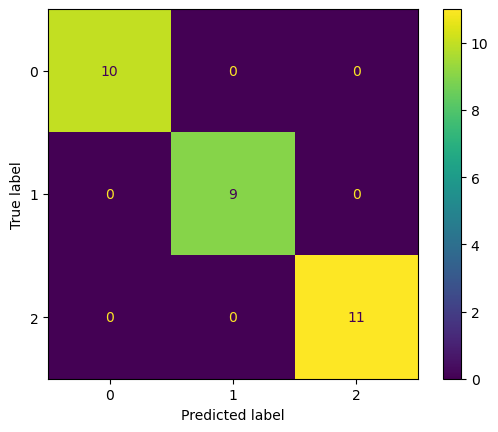

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
 
# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target
 
# Divide the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Create a CART template
tree_classifier = DecisionTreeClassifier(random_state=42)
 
#Train the model on the training data
tree_classifier.fit(X_train, y_train)

#Make predictions on test data
y_pred = tree_classifier.predict(X_test)
 
#Calculate the accuracy of the model<code>
accuracy = accuracy_score(y_test, y_pred)
print("Model accuracy:", accuracy)
 
#View the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=tree_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=tree_classifier.classes_)
disp.plot()
